In [1]:
import pynucastro as pyna
from pynucastro.screening import chugunov_2009

In [2]:
rl = pyna.ReacLibLibrary()

nucs = ["p", "he4",
        "c12", "o16", "ne20",
        "mg24", "si28", "s32",
        "ar36", "ca40", "ti44",
        "cr48", "fe52", "ni56",
        "al27", "p31", "cl35",
        "k39", "sc43", "v47",
        "mn51", "co55",
        "n13", "n14", "f18",
        "ne21", "na22", "na23"]

subch = rl.linking_nuclei(nucs)

other = [(("c12", "c12"), ("mg23", "n"), ("mg24")),
         (("o16", "o16"), ("s31", "n"), ("s32")),
         (("c12", "o16"), ("si27", "n"), ("si28"))]

for r, p, mp in other:
    rfilter = pyna.RateFilter(reactants=r,
                              products=p)
    _library = rl.filter(rfilter)
    r = _library.get_rates()[0]
    r.modify_products(mp)
    subch += _library

rc = pyna.PythonNetwork(libraries=[subch], symmetric_screening=True)
rc.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47", "mn51", "co55"])
rc.remove_nuclei(["cl35", "k39", "sc43", "v47", "mn51", "co55"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
using approximate rate Cr48 + He4 ⟶ Fe52 + 𝛾
using approximate rate Fe52 ⟶ Cr48 + He4
using approximate rate Fe52 + He4 ⟶ Ni56 + 𝛾
using approximate rate Ni56 ⟶ Fe52 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate 

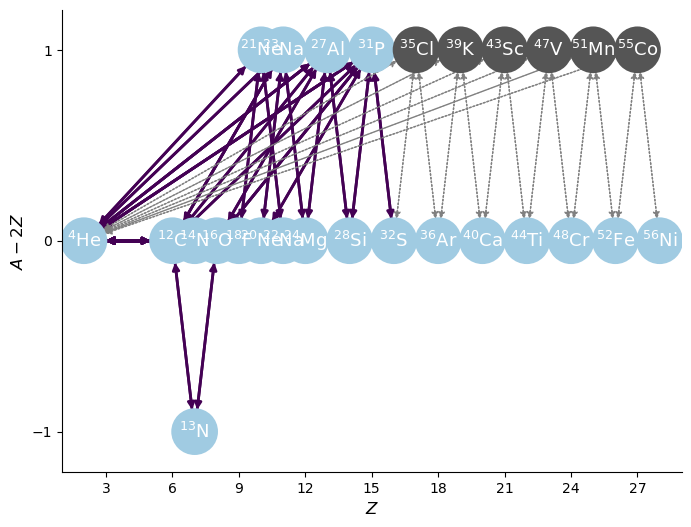

In [3]:
rc.plot(rotated=True)

In [4]:
rc.write_network("subcha.py")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import subcha

In [6]:
rho = 1.e6
T = 2.e9

X0 = np.zeros(subcha.nnuc)
X0[subcha.jhe4] = 0.99
X0[subcha.jn14] = 0.01

Y0 = X0/subcha.A

In [7]:
ydot = subcha.rhs(0, Y0, rho, T, chugunov_2009)
print(ydot)

[ 0.00000000e+00 -3.35051007e+03  1.00643238e+00  0.00000000e+00
 -3.34749078e+03  0.00000000e+00  3.34749078e+03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [8]:
tmax = 1.e-3

sol = solve_ivp(subcha.rhs, [0, tmax], Y0, method="BDF", jac=subcha.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-10)

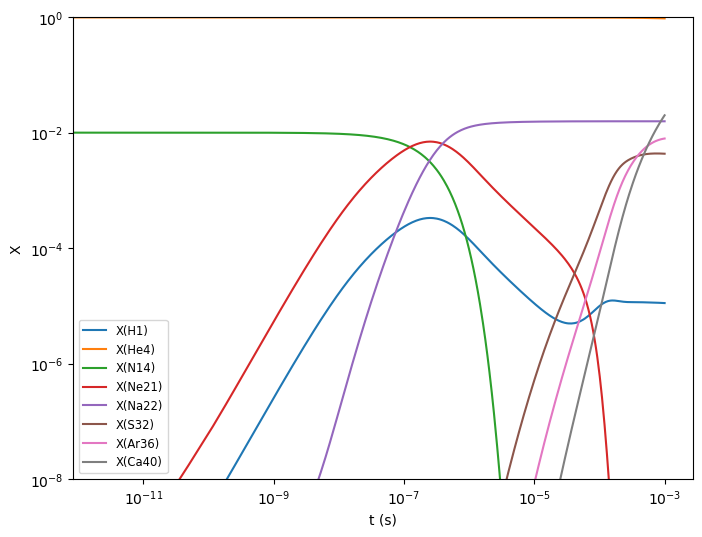

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

for i in range(subcha.nnuc):
    if (sol.y[i,:]).max() > threshold:
        ax.loglog(sol.t, sol.y[i,:] * subcha.A[i], label=f"X({subcha.names[i].capitalize()})")

ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

In [10]:
len(sol.t)

266

In [11]:
sum = 0.0
for n in range(subcha.nnuc):
    print(subcha.names[n], sol.y[n,-1]*subcha.A[n])
    sum += sol.y[n,-1]*subcha.A[n]

h1 1.1182017503548135e-05
he4 0.9501234835426305
c12 0.00041421018807020446
n13 4.732542522551965e-09
n14 6.1527495949852915e-24
o16 0.00013555530713842362
f18 1.63376970942673e-18
ne20 3.5997264018009835e-05
ne21 4.1475256200768736e-10
na22 0.01571428527978304
na23 1.0336383078966952e-06
mg24 5.665626244394154e-05
al27 0.00016982917743477087
si28 0.0006524065969341559
p31 0.00015027099540079495
s32 0.004311813206799218
ar36 0.007905861861591998
ca40 0.019962679209173315
ti44 0.0003515133495005587
cr48 3.213612126105699e-06
fe52 3.343483448910993e-09
ni56 3.639444609917827e-13


Now let's try to output at 50 different times

In [12]:
tfirst = 1.e-10
tmax = 1.e-3
npts = 100
times = np.logspace(np.log10(tfirst), np.log10(tmax), npts)
times

array([1.00000000e-10, 1.17681195e-10, 1.38488637e-10, 1.62975083e-10,
       1.91791026e-10, 2.25701972e-10, 2.65608778e-10, 3.12571585e-10,
       3.67837977e-10, 4.32876128e-10, 5.09413801e-10, 5.99484250e-10,
       7.05480231e-10, 8.30217568e-10, 9.77009957e-10, 1.14975700e-09,
       1.35304777e-09, 1.59228279e-09, 1.87381742e-09, 2.20513074e-09,
       2.59502421e-09, 3.05385551e-09, 3.59381366e-09, 4.22924287e-09,
       4.97702356e-09, 5.85702082e-09, 6.89261210e-09, 8.11130831e-09,
       9.54548457e-09, 1.12332403e-08, 1.32194115e-08, 1.55567614e-08,
       1.83073828e-08, 2.15443469e-08, 2.53536449e-08, 2.98364724e-08,
       3.51119173e-08, 4.13201240e-08, 4.86260158e-08, 5.72236766e-08,
       6.73415066e-08, 7.92482898e-08, 9.32603347e-08, 1.09749877e-07,
       1.29154967e-07, 1.51991108e-07, 1.78864953e-07, 2.10490414e-07,
       2.47707636e-07, 2.91505306e-07, 3.43046929e-07, 4.03701726e-07,
       4.75081016e-07, 5.59081018e-07, 6.57933225e-07, 7.74263683e-07,
      

In [15]:
t = 0.0
state = np.zeros((npts+1, subcha.nnuc))
state[0, :] = np.array(Y0)
for i in range(npts):
    tend = times[i]
    dt = tend - t
    sol = solve_ivp(subcha.rhs, [0, dt], state[i, :], method="BDF", jac=subcha.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-10)
    t += dt
    state[i+1, :] = np.array(sol.y[:,-1])

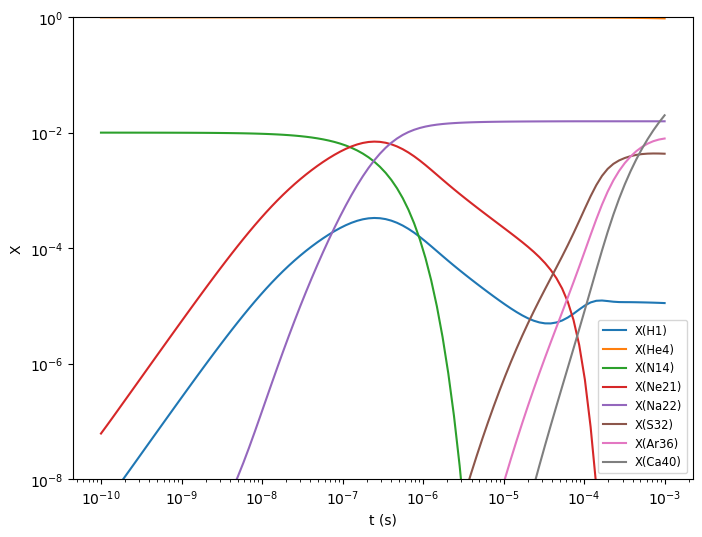

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

for i in range(subcha.nnuc):
    if (state[1:,i]).max() > threshold:
        ax.loglog(times, state[1:,i] * subcha.A[i], label=f"X({subcha.names[i].capitalize()})")

ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

In [22]:
print(state[-1, :] * subcha.A)

[1.11820166e-05 9.50123541e-01 4.14209940e-04 4.73253911e-09
 6.15531261e-24 1.35555201e-04 1.63389772e-18 3.59972352e-05
 4.14784750e-10 1.57142853e-02 1.03363761e-06 5.66562152e-05
 1.69829055e-04 6.52407061e-04 1.50271109e-04 4.31183385e-03
 7.90598072e-03 1.99624617e-02 3.51533308e-04 3.21464351e-06
 3.34641638e-09 3.64603213e-13]
